In [10]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import torch.nn.functional as F
import numpy as np

# torch.manual_seed(1)

# Enlarge EPOCH to 5, and set lower learning rate
EPOCH = 10
LR = 0.0001
DOWNLOAD_MNIST = False

train_data = torchvision.datasets.MNIST(root='./mnist/', train=True, transform=torchvision.transforms.ToTensor(),
                                        download=DOWNLOAD_MNIST)
test_data = torchvision.datasets.MNIST(root='./mnist/', train=False)
print(train_data.train_data.shape)

train_x = torch.unsqueeze(train_data.train_data, dim=1).type(torch.FloatTensor) / 255.
train_y = train_data.train_labels
print(train_x.shape)

test_x = torch.unsqueeze(test_data.test_data, dim=1).type(torch.FloatTensor)[:10000] / 255.  # Tensor on GPU
test_y = test_data.test_labels[:10000]

torch.Size([60000, 28, 28])
torch.Size([60000, 1, 28, 28])


E:\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
E:\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
E:\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
E:\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [11]:
test_x.shape

torch.Size([10000, 1, 28, 28])

In [12]:
import matplotlib.pyplot as plt

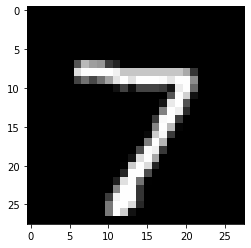

In [13]:
plt.imshow(test_x[0,0,:,:].numpy(), 'gray')

In [14]:
test_y[:10]

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])

### 定义神经网络类Net
#### 1. 实现卷积层与全连接层代码
#### 2. 增加dropout与BN技巧

In [15]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Two Layer CNN
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True)
        # Two Layer Full-Connected Network
        self.fc1 = nn.Linear(32 * 7 * 7, 500)
        self.fc2 = nn.Linear(500, 10)
        # Batch Normalization Layers
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.batchnorm2 = nn.BatchNorm2d(32)
        # Drop Out Layer
        self.dropout = nn.Dropout(p=0)
    
    def forward(self, x):
        x1 = F.relu(self.conv1(x))
        x2 = F.max_pool2d(x1, (2,2)) # Max Pooling with pooling kernel size 2X2
        x2 = self.batchnorm1(x2)     # Batch Normalization with switch
        x3 = F.relu(self.conv2(x2))  
        x4 = F.max_pool2d(x3, (2,2)) # Max Pooling with pooling kernel size 2X2
        x4 = self.batchnorm2(x4)     # Batch Normalization with switch
        x5 = x4.view(x4.size(0), -1)
        x5 = self.dropout(x5)        # Add Dropout with switch
        x6 = F.relu(self.fc1(x5))
        output = F.log_softmax(self.fc2(x6), dim=1)
        
        return output

In [16]:
print(torch.cuda.is_available())

True


In [17]:
# Use multimodels for ensambling
net = Net()

device = torch.device('cuda:0')
net.to(device)

print(net)
for parameters in net.parameters():
    print(parameters.size())

optimizer = torch.optim.Adam(net.parameters(), lr=LR)

# loss_func = nn.MSELoss()
loss_func = nn.CrossEntropyLoss()

# Enlarge dataSize and BatchSize
data_size = 60000
batch_size = 50

max_accuracy = 0
best_params = []

for epoch in range(EPOCH):
    random_indx = np.random.permutation(data_size)
    for batch_i in range(data_size // batch_size):
        indx = random_indx[batch_i * batch_size:(batch_i + 1) * batch_size]

        b_x = train_x[indx, :].to(device)
        b_y = train_y[indx].to(device)

        output = net(b_x)
            
        loss = loss_func(output, b_y)
        
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()

        if batch_i % 50 == 0:
            test_output = net(test_x.to(device))
            
            # Use voting mechanism to deicide final predicted label
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = torch.sum(pred_y == test_y.to(device)).type(torch.FloatTensor) / test_y.size(0)
            
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.cpu().numpy(), '| test accuracy: %.4f' % accuracy)
            if(accuracy > max_accuracy): 
                max_accuracy = accuracy
                torch.save(net, 'best_net.pkl')

test_output = net(test_x[:10].to(device))
pred_y = torch.max(test_output, 1)[1].data.squeeze()  # move the computation in GPU

print(pred_y, 'prediction number')
print(test_y[:10], 'real number')
print('Max Accuracy: %.4f' % max_accuracy)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1568, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (batchnorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0, inplace=False)
)
torch.Size([16, 1, 3, 3])
torch.Size([16])
torch.Size([32, 16, 3, 3])
torch.Size([32])
torch.Size([500, 1568])
torch.Size([500])
torch.Size([10, 500])
torch.Size([10])
torch.Size([16])
torch.Size([16])
torch.Size([32])
torch.Size([32])
Epoch:  0 | train loss: 2.3406 | test accuracy: 0.1445
Epoch:  0 | train loss: 0.3031 | test accuracy: 0.9443
Epoch:  0 | train loss: 0.1408 | test accuracy: 0.9621
Epoch:  0 | train loss: 0.0821 | test accuracy: 0.9704
Epoch:  0 | train loss: 0.1

In [9]:
net = torch.load('best_net.pkl')

test_output = net(test_x[:20].to(device))
pred_y = torch.max(test_output, 1)[1].data.squeeze()  # move the computation in GPU

print(pred_y.cpu().numpy(), 'prediction number')
print(test_y[:20].cpu().numpy(), 'real number')

[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4] prediction number
[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4] real number


In [10]:
test_x[:1].shape

torch.Size([1, 1, 28, 28])

In [1]:
plt.imshow(test_x[:1].numpy().squeeze(), 'gray')

NameError: name 'plt' is not defined

In [ ]:
import num